<a href="https://colab.research.google.com/github/dsevero/dsevero.com/blob/master/notebooks/On_Distributed_Quantization_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolz import pipe
from collections import defaultdict
from itertools import product
from joblib import Parallel, delayed
import multiprocessing
import scipy.stats as stats
CPU_COUNT = multiprocessing.cpu_count()

colors_hex = ['#FF0000', '#0000FF']
cm_bright = ListedColormap(colors_hex)

parallel = Parallel(n_jobs=CPU_COUNT, verbose=10)

# 1. On-the-line quantizer

## 1.1 Generate data

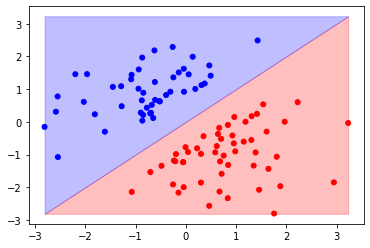

In [2]:
def _data_fixture():
    X = np.array([*[[0.2*i + 0.1, 0.2*(i+1)] for i in range(1, 5)],
                  *[[0.2*i + 0.1, 0.2*(i-1)] for i in range(1, 5)]])
    y = (X[:, 0] < X[:, 1]).astype(int)
    return X, 2*y - 1

def make_normal_unit_vector(d):
    v = np.append(-1, np.ones(d-1))
    return v/np.sqrt(v@v)

def generate_data(N, d, sep=.25, seed=None):
    X = np.random.RandomState(seed).normal(size=(N, d))
    w = make_normal_unit_vector(d)
    y = np.sign((X*w).sum(axis=1))
    X += sep*y[:, np.newaxis]*w
    return X, y

def make_potential_boundaries(X):
    return pipe(X, np.ravel, np.unique, np.sort)

def plot(X, y, boundaries=None, **plot_kwargs):
    fig, ax = plt.subplots(**plot_kwargs)
    ax.scatter(*X.T, c=y, s=25, cmap=cm_bright)
    x = np.linspace(X.min(), X.max(), 100)
    ax.fill_between(x, x, x[0], alpha=0.25, color=colors_hex[0])
    ax.fill_between(x, x, x[-1], alpha=0.25, color=colors_hex[1])

    if boundaries is not None:
        for b in boundaries:
            ax.vlines(b, 0, 1, linestyles='dashed')
            ax.hlines(b, 0, 1, linestyles='dashed')

    return fig, ax

X, y = generate_data(100, 2, sep=0.5)
plot(X, y);

## 1.2 Algorithm

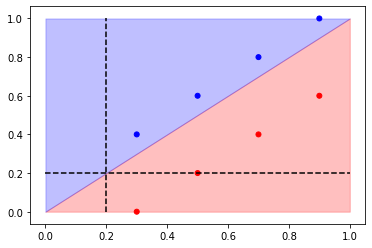

In [3]:
def _min_gap_error(X, y, si, sl=-1):
    mask = ((X > sl) & (X <= si)).all(axis=1)
    return min(((y == c) & mask).sum() for c in [-1, 1])

def ontheline_quantizer(X, y, R=None, k=None):
    assert ((R is None) and (k is not None) or
            (R is not None) and (k is None))
    
    k = k or 2**R-1
    s = make_potential_boundaries(X)
    E = np.zeros((len(s), k+1))
    A = defaultdict(lambda: defaultdict(set))
    for i, si in enumerate(s):
        E[i, 0] = _min_gap_error(X, y, si)

    for i, si in enumerate(s):
        for b in range(1, k+1):
            if i == 0:
                E[i, b] = 0
                A[i][b] = set()
            else:
                (E[i, b],
                 l_star,
                 sl_star) = min([E[l, b-1] + _min_gap_error(X, y, si, sl), l, sl]
                                for l, sl in enumerate(s[:i]))
                A[i][b] = A[l_star][b-1].union({sl_star})

    return E, A, A[len(s)-1][k]

X, y = _data_fixture()
E, A, d = ontheline_quantizer(X, y, R=1)
plot(X, y, d);

## 1.3 Sanity Checks

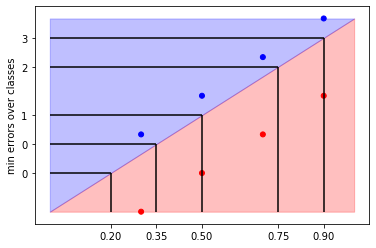

In [4]:
def test_zero_boundaries():
    X, y = _data_fixture()
    plot(X, y);
    boundaries = [0.20, 0.35, 0.50, 0.75, 0.90]
    errors = [0, 0, 1, 2, 3]
    for b, e in zip(boundaries, errors):
        assert _min_gap_error(X, y, b) == e
        plt.vlines(b, 0, b, linestyles='solid')
        plt.hlines(b, 0, b, linestyles='solid')
        plt.xticks(boundaries)
        plt.yticks(boundaries, labels=[f'{e}' for e in errors])
        plt.ylabel('min errors over classes')

test_zero_boundaries()

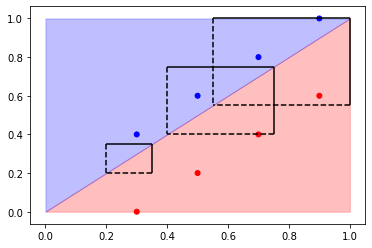

In [5]:
def draw_square(*edges):
    plt.vlines(edges[0], edges[0], edges[1], linestyles='solid')
    plt.vlines(edges[1], edges[0], edges[1], linestyles='dashed')
    plt.hlines(edges[0], edges[0], edges[1], linestyles='solid')
    plt.hlines(edges[1], edges[0], edges[1], linestyles='dashed')

def test_gap_boundaries():
    X, y = _data_fixture()
    plot(X, y);
    gaps = [(.35, .20), (.75, .40), (1.0, .55)]
    errors = [0, 0, 1]
    for g, e in zip(gaps, errors):
        assert _min_gap_error(X, y, *g) == e
        draw_square(*g)

test_gap_boundaries()

## 1.4 Run on separable data

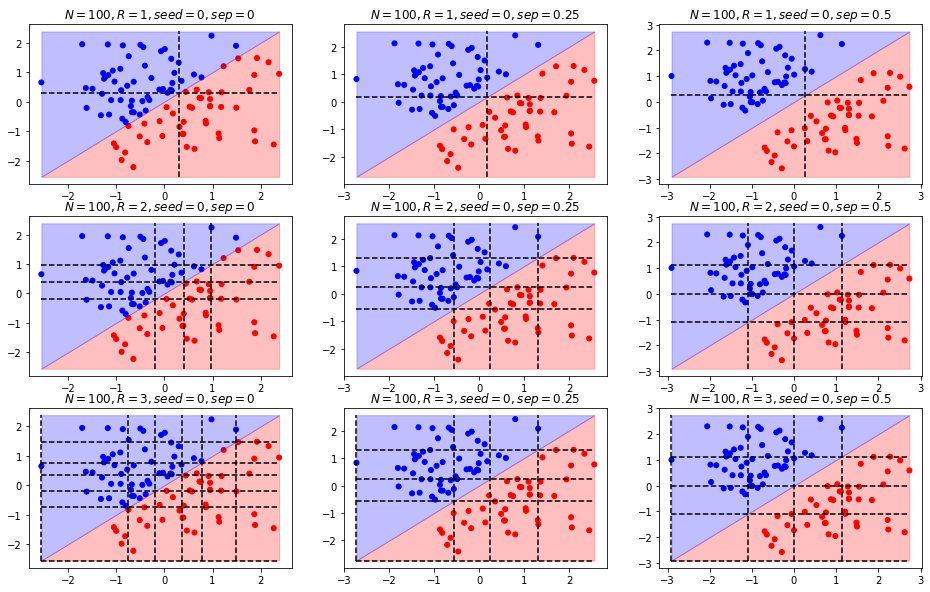

In [6]:
N = 100
seed = 0
R_space = [1, 2, 3]
sep_space = [0, 0.25, 0.5]

plt.figure(figsize=(16,10))
metrics = list()
for i, (R, separation) in enumerate(product(R_space, sep_space), 1):
    X, y = generate_data(N, 2, separation, seed)
    E, A, boundaries = ontheline_quantizer(X, y, R)
    plt.subplot(3, 3, i)

    plt.scatter(*X.T, c=y, s=25, cmap=cm_bright)
    x = np.linspace(X.min(), X.max(), 100)
    plt.fill_between(x, x, x[0], alpha=0.25, color=colors_hex[0])
    plt.fill_between(x, x, x[-1], alpha=0.25, color=colors_hex[1])

    for b in boundaries:
        plt.vlines(b, X.min(), X.max(), linestyles='dashed')
        plt.hlines(b, X.min(), X.max(), linestyles='dashed')
    
    plt.title(f'$N={N}, R={R}, seed={seed}, sep={separation}$')

    metrics.append({'loss': E[-1][-1]/N,
                    'R': R,
                    'separation': separation})

## 1.5 Does separation make the problem easier?

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  19 out of  30 | elapsed:    7.0s remaining:    4.1s
[Parallel(n_jobs=8)]: Done  23 out of  30 | elapsed:   11.8s remaining:    3.6s
[Parallel(n_jobs=8)]: Done  27 out of  30 | elapsed:   13.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:   15.5s finished


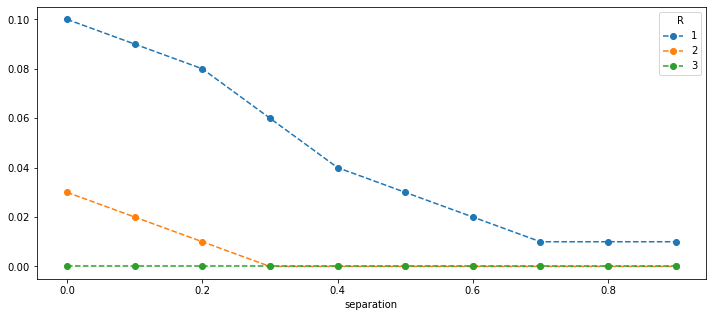

In [7]:
N = 100
seed = 0
R_space = [1, 2, 3]
sep_space = np.arange(0, 1, 0.1)

@delayed
def single_run(R, separation):
    X, y = generate_data(N, 2, separation, seed)
    E, _, _ = ontheline_quantizer(X, y, R)
    return {'loss': E[-1][-1]/N,
             'R': R,
             'separation': separation}

metrics = parallel(single_run(R, s) for R, s in product(R_space, sep_space))

(pd
 .DataFrame(metrics)
 .pivot('separation', 'R', 'loss')
 .plot(style='o--', figsize=(12,5)))

plt.show();

## 1.6 Boundary quantization (new, not part of the paper)

3 (100, 2) [0.15360419 0.87653616] 1.0 (43, 1, <ufunc 'less'>, 0) (43,)
2 (43, 2) [ 0.66425226 -0.23100552] -1.0 (22, 1, <ufunc 'less'>, 0) (22,)
1 (22, 2) [-1.4631614   0.24955527] 1.0 (5, 0, <ufunc 'greater'>, 0) (5,)


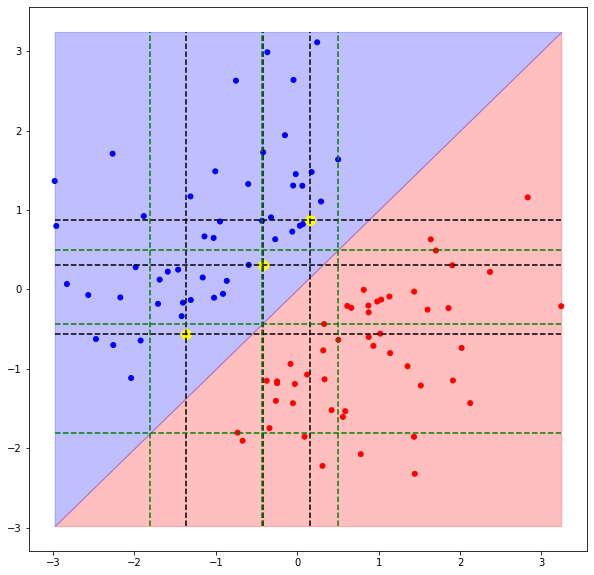

In [8]:
from matplotlib.colors import BASE_COLORS
seed = None
X, y = generate_data(N, 2, separation, seed)

def rotate(X, angle=np.pi/4):
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    return X.dot(R.T)

RX = rotate(X)
plot(X, y, figsize=(10, 10));

def nearestToBoundary_quantizer(mask=None, depth=5, boundaries=[]):
    mask = np.arange(y.shape[0]) if mask is None else mask
    i = np.abs(RX[mask, 0]).argmin()
    d = X[mask][i, :]

    plt.scatter(*d, c='yellow', s=100);
    plt.vlines(d[0], X.min(), X.max(), linestyles='dashed');
    plt.hlines(d[1], X.min(), X.max(), linestyles='dashed');
    
    max_error = max(((y[mask][f(X[mask], d).all(axis=1)] != c).sum(), i, f, c)
                    for i, (c, f) in enumerate(product([0, 1], [np.greater, np.less])))

    _, _, f, c = max_error
    new_mask = mask[f(X[mask], d).all(axis=1)]
    print(depth,X[mask].shape, X[i], y[i], max_error, new_mask.shape)
    if depth > 1:
        nearestToBoundary_quantizer(new_mask, depth-1, boundaries+[d])

nearestToBoundary_quantizer(depth=3)
E, A, boundaries = ontheline_quantizer(X, y, 2)
for b in boundaries:
    plt.vlines(b, X.min(), X.max(), 'green', linestyles='dashed')
    plt.hlines(b, X.min(), X.max(), 'green', linestyles='dashed')

## 1.7 Questions and Comments
1. On-the-line quantizer minimizes consistency error, but does it minimize risk? It's a bit odd that the quantizer is data dependent. It feels like there should be a better strategy to quantize the classification regions.

2. If we allow the nodes to accumulate samples, we can apply Shannon's source coding theorem and achieve better compression.

3. By iterating over the points nearest to the margins/boundaries, can we achieve a lower complexity class for the algorithm? This may require removing the "on-the-line" condition (see the incomplete "1.6 Boundary Quantization section")

4. What happens if a node is hijacked? What interesting attacks are possible?

5. If a single node has more than one feature, can local statistics be used to increase compression? For example, by quantizing the first PCA component.

6. Instead of distributed quantization and centralized classification, try distributed classification with centralized meta-classification (e.g. voting)

7. The number of bits per node is fixed, but features with higher entropy will require more bits to properly quantize than those with lower entropy.

# 2. Learning quantization

## 2.1 Generating polynomials

/home/dsevero/miniconda3/envs/dsevero.com/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


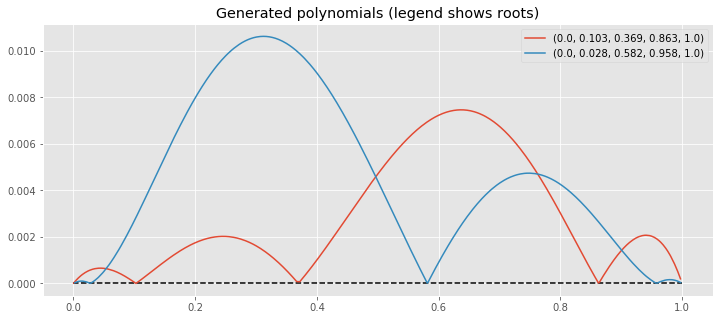

In [9]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit
plt.style.use('ggplot')


def add_box_boundaries(B):
    return jnp.hstack([np.zeros((B.shape[0],1)), 
                       B, 
                       np.ones((B.shape[0],1))])

def σ(x):
    return 1/(1 + jnp.exp(-x))

def classify(logit):
    return (logit > 0.5)

def compute_diff(S, B):
    N, d, k = S.shape[0], *B.shape
    return (jnp.repeat(jnp.expand_dims(S, -1), k, axis=-1)
                       - jnp.repeat(jnp.expand_dims(B, 0), N, axis=0))

def poly_eval_from_roots(B: '(dim, n_roots)', S):
    p = jnp.product(compute_diff(S, B), axis=-1)
    return jnp.abs(p)


(N, d, k) = 1000, 2, 3
B = np.stack([np.sort(np.random.uniform(0, 1, size=k))
              for _ in range(d)])
B = add_box_boundaries(B)
S = np.random.uniform(0, 1, size=(N, d))
z = poly_eval_from_roots(B, S)

plt.figure(figsize=(12,5))
for i in range(d):
    idx = jnp.argsort(S[:, i])
    roots = jnp.round(B[i], 3)
    plt.plot(S[idx, i], z[idx, i])
plt.title('Generated polynomials (legend shows roots)')
plt.hlines(0, 0, 1, linestyles='dashed')
plt.legend([f'{tuple(roots)}' for roots in jnp.round(B, 3)]);
plt.show()

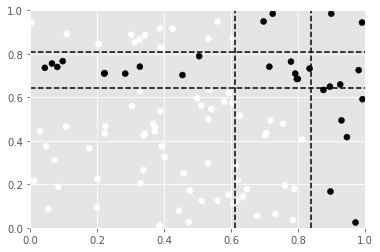

In [10]:
N, d, k = 100, 2, 2
S = np.random.uniform(0, 1, size=(N, d))
B = jnp.stack([np.sort(np.random.uniform(0, 1, size=k))
              for _ in range(d)])
yhat = jnp.array(np.random.choice([-1, +1], (k+1)**d))
θ = [B, yhat]

def Q(θ, S, return_multi=False):
    B, yhat = θ
    codes_multi_dim = (compute_diff(S, add_box_boundaries(B)) <= 0).argmax(axis=2) - 1
    codes_flat = codes_multi_dim.clip(0) @ np.array([(k+1)**i for i in range(d)])
    return (codes_flat, codes_multi_dim) if return_multi else codes_flat

def q(θ, S):
    B, yhat = θ
    N = S.shape[0]
    z = poly_eval_from_roots(B, S)
    codewords = Q(θ, S)
    return σ(yhat[codewords]*jnp.product(z, axis=1))

def plot_2d_tiling(θ, θ_star, S):
    B, yhat = θ
    y_true = classify(q(θ_star, S))
    plt.vlines(B[0], 0, 1, linestyles='dashed')
    plt.hlines(B[1], 0, 1, linestyles='dashed')
    plt.scatter(*S.T, c=y_true)
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.gray()
    
plot_2d_tiling(θ, θ, S)
plt.show()

## 2.2 Realizable case: $C \in \mathcal{H}_{k,d}$

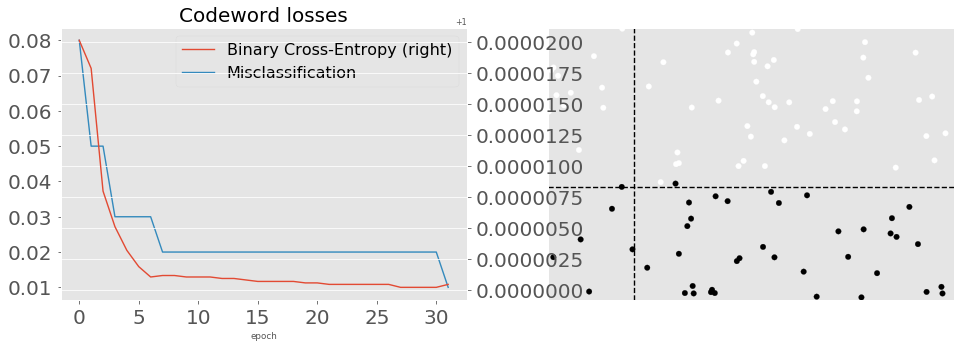

In [11]:
from jax import grad
import pandas as pd


def binary_cross_entropy(p, q):
    return -(p*jnp.log2(q) + (1-p)*jnp.log2(1-q))[q > 0][q < 1]

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

# def codeword_loss(θ, S, p):
#     q_ = q(θ, S)
#     return binary_cross_entropy(p, q_).mean()

def codeword_loss(θ, S, p):
    q_ = q(θ, S)
    mask = (classify(p) != classify(q_))
    return binary_cross_entropy(p, q_)[mask].mean()

N, d, k = 100, 2, 1
S = np.random.uniform(0, 1, size=(N, d))
B_star = jnp.stack([np.sort(np.random.uniform(0, 1, size=k))
                    for _ in range(d)])
yhat_star = jnp.array(np.random.choice([-1.0, +1.0], (k+1)**d))

B = jnp.stack([np.sort(np.random.uniform(0, 1, size=k))
              for _ in range(d)])
# yhat = jnp.array(np.random.choice([-1, +1], (k+1)**d))
yhat = yhat_star

θ_star = [B_star, yhat_star]
θ = [B, yhat]

q_star = q(θ_star, S)
y_star = classify(q_star)


grad_loss = grad(codeword_loss)
lr = 1e1

metrics = list()
for epoch in range(100):
    dθ = grad_loss(θ, S, q_star)
    θ[0] -= lr*dθ[0]
    
    q_ = q(θ, S)
    y_pred = classify(q_)
    loss_mce = jnp.min([1 - accuracy(y_star, y_pred),
                        1 - accuracy(y_star, 1-y_pred)])
    
    metrics.append({
        'loss_bce': float(codeword_loss(θ, S, q_star)),
        'loss_mce': float(loss_mce),
        'epoch': epoch,
    })
    
    if loss_mce < 0.01:
        break

plt.style.use('seaborn-paper')

params = {'legend.fontsize': 16,
          'legend.handlelength': 2,
          'font.size': 20}
plt.rcParams.update(params)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

(pd.DataFrame(metrics)
   .set_index('epoch')
   .rename(columns={
       'loss_mce': 'Misclassification',
       'loss_bce': 'Binary Cross-Entropy'
   })
   .plot(secondary_y='Binary Cross-Entropy',
         fontsize=20,
         ax=axes[0]));

plt.title('Codeword losses', fontsize=20)
B = θ[0]
if d <= 2:
    axes[1].vlines(B[0], 0, 1, linestyles='dashed')
    axes[1].hlines(B[1], 0, 1, linestyles='dashed')
    axes[1].scatter(*S.T, c=y_star)
    axes[1].set_ylim(0,1)
    axes[1].set_xlim(0,1)
    axes[1].set_yticks([])
    axes[1].set_xticks([])
plt.show()

## 2.3 Linearly seperable data

In [13]:
# from jax import grad
# import pandas as pd


# def binary_cross_entropy(p, q):
#     return -(p*jnp.log2(q) + (1-p)*jnp.log2(1-q))[q > 0][q < 1]

# def accuracy(y_true, y_pred):
#     return (y_true == y_pred).mean()

# def codeword_loss(θ, S, p):
#     q_ = q(θ, S)
#     mask = (classify(p) != classify(q_))
#     return binary_cross_entropy(p, q_)[mask].mean()

# N, d, k = 100, 2, 2
# S, y = generate_data(N, d, seed=1)
# yhat = jnp.array([+1.0, +1.0, +1.0, -1.0, +1.0, +1.0, -1.0, -1.0, +1.0])
# B = jnp.stack([np.sort(np.random.uniform(0, 1, size=k))
#               for _ in range(d)])
# θ = [B, yhat]

# q_star = σ(S @ np.array([-1, 1]))
# y_star = classify(q_star)


# grad_loss = grad(codeword_loss)
# lr = 2e0

# metrics = list()
# for epoch in range(300):
#     dθ = grad_loss(θ, S, q_star)
#     θ[0] -= lr*dθ[0]
    
#     q_ = q(θ, S)
#     y_pred = classify(q_)
#     loss_mce = jnp.min([1 - accuracy(y_star, y_pred),
#                         1 - accuracy(y_star, 1-y_pred)])
    
#     metrics.append({
#         'loss_bce': float(codeword_loss(θ, S, q_star)),
#         'loss_mce': float(loss_mce),
#         'epoch': epoch,
#     })
    
#     if loss_mce < 0.01:
#         break

# plt.style.use('seaborn-paper')

# params = {'legend.fontsize': 16,
#           'legend.handlelength': 2,
#           'font.size': 20}
# plt.rcParams.update(params)

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

# (pd.DataFrame(metrics)
#    .set_index('epoch')
#    .rename(columns={
#        'loss_mce': 'Misclassification',
#        'loss_bce': 'Binary Cross-Entropy'
#    })
#    .plot(secondary_y='Binary Cross-Entropy',
#          fontsize=20,
#          ax=axes[0]));

# plt.title('Codeword losses', fontsize=20)
# B = θ[0]
# colors = np.array(['r', 'g'])[((yhat[Q([B, yhat], S)]+1)/2).astype(int)]
# if d <= 2:
#     axes[1].vlines(B[0], 0, 1, linestyles='dashed')
#     axes[1].hlines(B[1], 0, 1, linestyles='dashed')
#     for i in [-1, 1]:
#         mask = y == i
#         axes[1].scatter(*S[mask].T, c=colors[mask], marker=['x', 'o'][int((i+1)/2)])
#     axes[1].set_ylim(0,1)
#     axes[1].set_xlim(0,1)
#     axes[1].set_yticks([])
#     axes[1].set_xticks([])
# plt.show()

# References

[1] Hanna, Osama A., et al. "On Distributed Quantization for Classification." IEEE Journal on Selected Areas in Information Theory (2020).